In [100]:
!pip install plydata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

In [102]:
pn.options.dpi = 300

In [103]:
cdnow_raw_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/CDNOW_master.txt',
                           sep = '\s+',
                           names = ['customer_id', 'date', 'quantity', 'price']
                           )

In [104]:
cdnow_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  69659 non-null  int64  
 1   date         69659 non-null  int64  
 2   quantity     69659 non-null  int64  
 3   price        69659 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [105]:
cdnow_df = cdnow_raw_df \
      .assign(
            date = lambda x: x['date'].astype(str)
      ) \
      .assign(
            date = lambda x: pd.to_datetime(x['date'])
      ) \
      .dropna()

In [106]:
# Cohort Analysis
cdnow_first_purchase_tbl = cdnow_df \
      .sort_values(['customer_id', 'date']) \
      .groupby('customer_id') \
      .first()

In [107]:
cdnow_first_purchase_tbl['date'].min()

Timestamp('1997-01-01 00:00:00')

In [108]:
cdnow_first_purchase_tbl['date'].max()

Timestamp('1997-03-25 00:00:00')

<AxesSubplot:xlabel='date'>

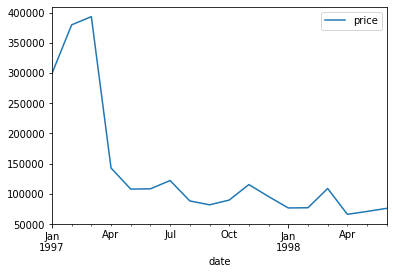

In [109]:
# Visualize : All purchases within cohort
cdnow_df \
      .reset_index() \
      .set_index('date') \
      [['price']] \
      .resample( 
            rule = 'MS'
      ) \
      .sum() \
      .plot()

In [110]:
ids = cdnow_df['customer_id'].unique()
ids_selected = ids[0:10]

In [111]:
cdnow_cust_id_subset_df = cdnow_df \
      [cdnow_df['customer_id'].isin(ids_selected)] \
      .groupby(['customer_id', 'date']) \
      .sum() \
      .reset_index()

In [112]:
cdnow_cust_id_subset_df

,customer_id,date,quantity,price
0,1,1997-01-01,1,11.77
1,2,1997-01-12,6,89.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54
5,3,1997-11-15,5,57.45
6,3,1997-11-25,4,20.96
7,3,1998-05-28,1,16.99
8,4,1997-01-01,2,29.33
9,4,1997-01-18,2,29.73


/usr/local/lib/python3.8/dist-packages/plotnine/geoms/geom_path.py:81: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


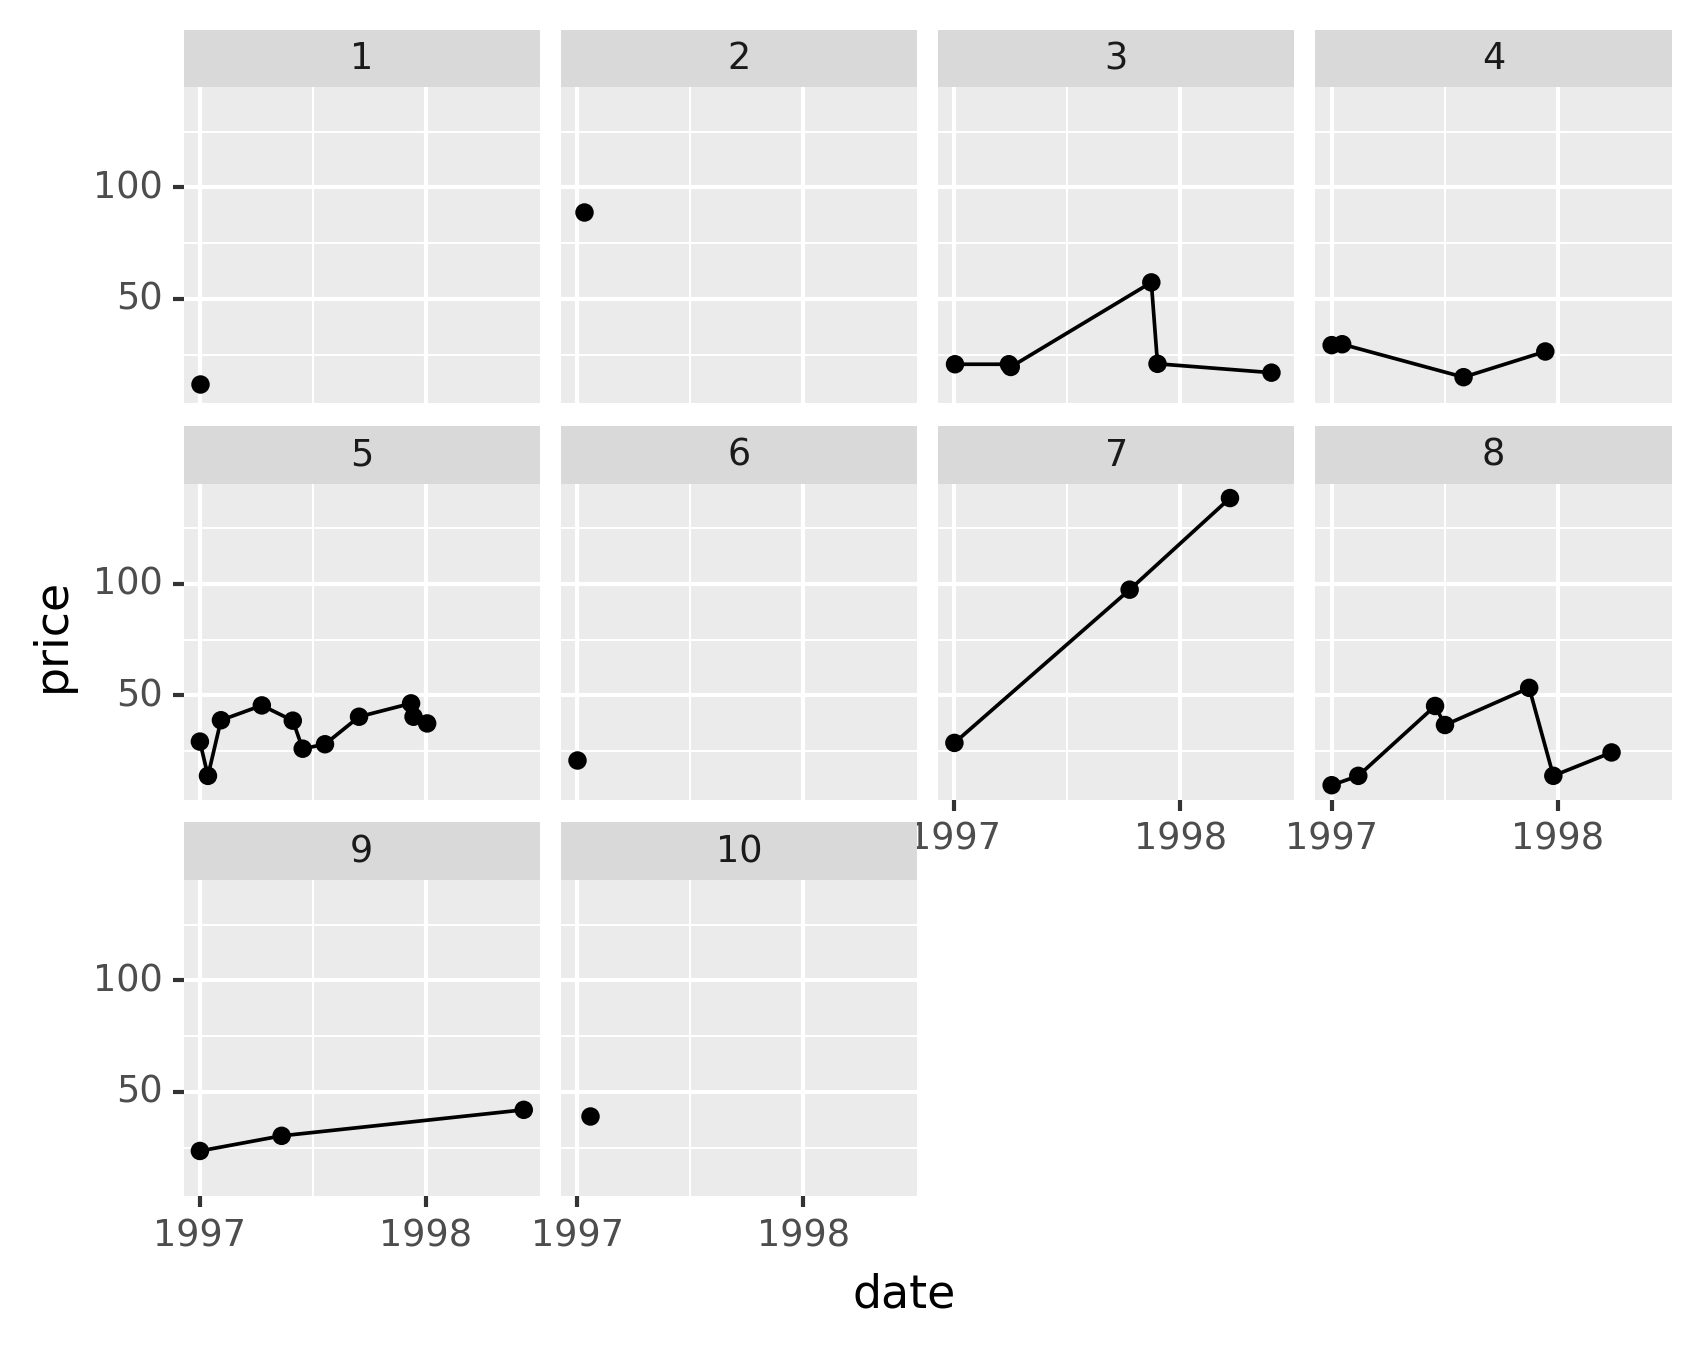

<ggplot: (8770930913142)>

In [113]:
pn.ggplot(cdnow_cust_id_subset_df,
          aes(x='date', y='price', group = 'customer_id')) \
      + pn.geom_line() \
      + pn.geom_point() \
      + pn.facet_wrap('customer_id') \
      + pn.scale_x_date(
            date_breaks = "1 year",
            date_labels = "%Y"
      )

In [114]:
# Machine Learning
# Time splitting

In [115]:
n_days = 90
max_date = cdnow_df['date'].max()
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd')

temporal_in_df = cdnow_df \
      [cdnow_df['date'] <= cutoff]

temporal_out_df = cdnow_df \
      [cdnow_df['date'] > cutoff]

In [117]:
# Feature Engineering (RFM)
# Make Targets from out data
targets_df = temporal_out_df \
      .drop('quantity', axis = 1) \
      .groupby('customer_id') \
      .sum() \
      .rename({'price': 'spend_90_total'}, axis = 1) \
      .assign(spend_90_flag = 1)

In [118]:
# Make Recency(Date) Features from in data
max_date = temporal_in_df['date'].max()

In [119]:
recency_features_df = temporal_in_df \
      [['customer_id', 'date']] \
      .groupby('customer_id') \
      .apply(
            lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1, 'day')
      ) \
      .to_frame() \
      .set_axis(['recency'], axis=1)

In [120]:
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [122]:
# Make Frequency(Count) Features from in data
frequency_features_df = temporal_in_df \
      [['customer_id', 'date']] \
      .groupby('customer_id') \
      .count() \
      .set_axis(['frequency'], axis=1)

In [123]:
# Make Price(Monetary) Features from in data
price_features_df = temporal_in_df \
      .groupby('customer_id') \
      .aggregate(
            {
                'price': ['sum', 'mean']
            }
      ) \
      .set_axis(['price_sum', 'price_mean'], axis = 1)

In [125]:
# Combine Features
features_df = pd.concat(
    [recency_features_df, frequency_features_df, price_features_df], axis = 1
) \
    .merge(
          targets_df,
          left_index = True,
           right_index = True,
           how = 'left'
    ) \
    .fillna(0)

In [126]:
# Machine Learning

In [127]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

In [128]:
# Next 90days spend prediction

In [129]:
y_spend = features_df['spend_90_total']

In [130]:
xgb_reg_spec = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 123
)

In [131]:
xgb_reg_model = GridSearchCV(
    estimator = xgb_reg_spec,
    param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]),
    scoring = 'neg_mean_absolute_error',
    refit = True,
    cv = 5
)

In [132]:
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [133]:
xgb_reg_model.best_score_

-9.799799543254297

In [134]:
xgb_reg_model.best_params_

{'learning_rate': 0.01}

In [135]:
xgb_reg_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [136]:
predictions_reg = xgb_reg_model.predict(X)

In [138]:
# Next 90 days spend probability
y_prob = features_df['spend_90_flag']

In [139]:
xgb_clf_spec = XGBClassifier(
    objective = 'binary:logistic',
    random_state = 123
)

In [140]:
xgb_clf_model = GridSearchCV(
    estimator = xgb_clf_spec,
    param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]),
    scoring = 'roc_auc',
    refit = True,
    cv = 5
    )

In [141]:
xgb_clf_model.fit(X, y_prob)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [142]:
xgb_clf_model.best_score_

0.8356508197983127

In [143]:
xgb_clf_model.best_params_

{'learning_rate': 0.01}

In [144]:
xgb_clf_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

In [145]:
predictions_clf = xgb_clf_model.predict_proba(X)

In [146]:
# Feature Importance
# Importance - Spend Amount Model
imp_spend_amount_dict = xgb_reg_model \
      .best_estimator_ \
      .get_booster() \
      .get_score(importance_type = 'gain')

In [153]:
imp_spend_amount_df = pd.DataFrame(
    data = {
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
    ) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
    )

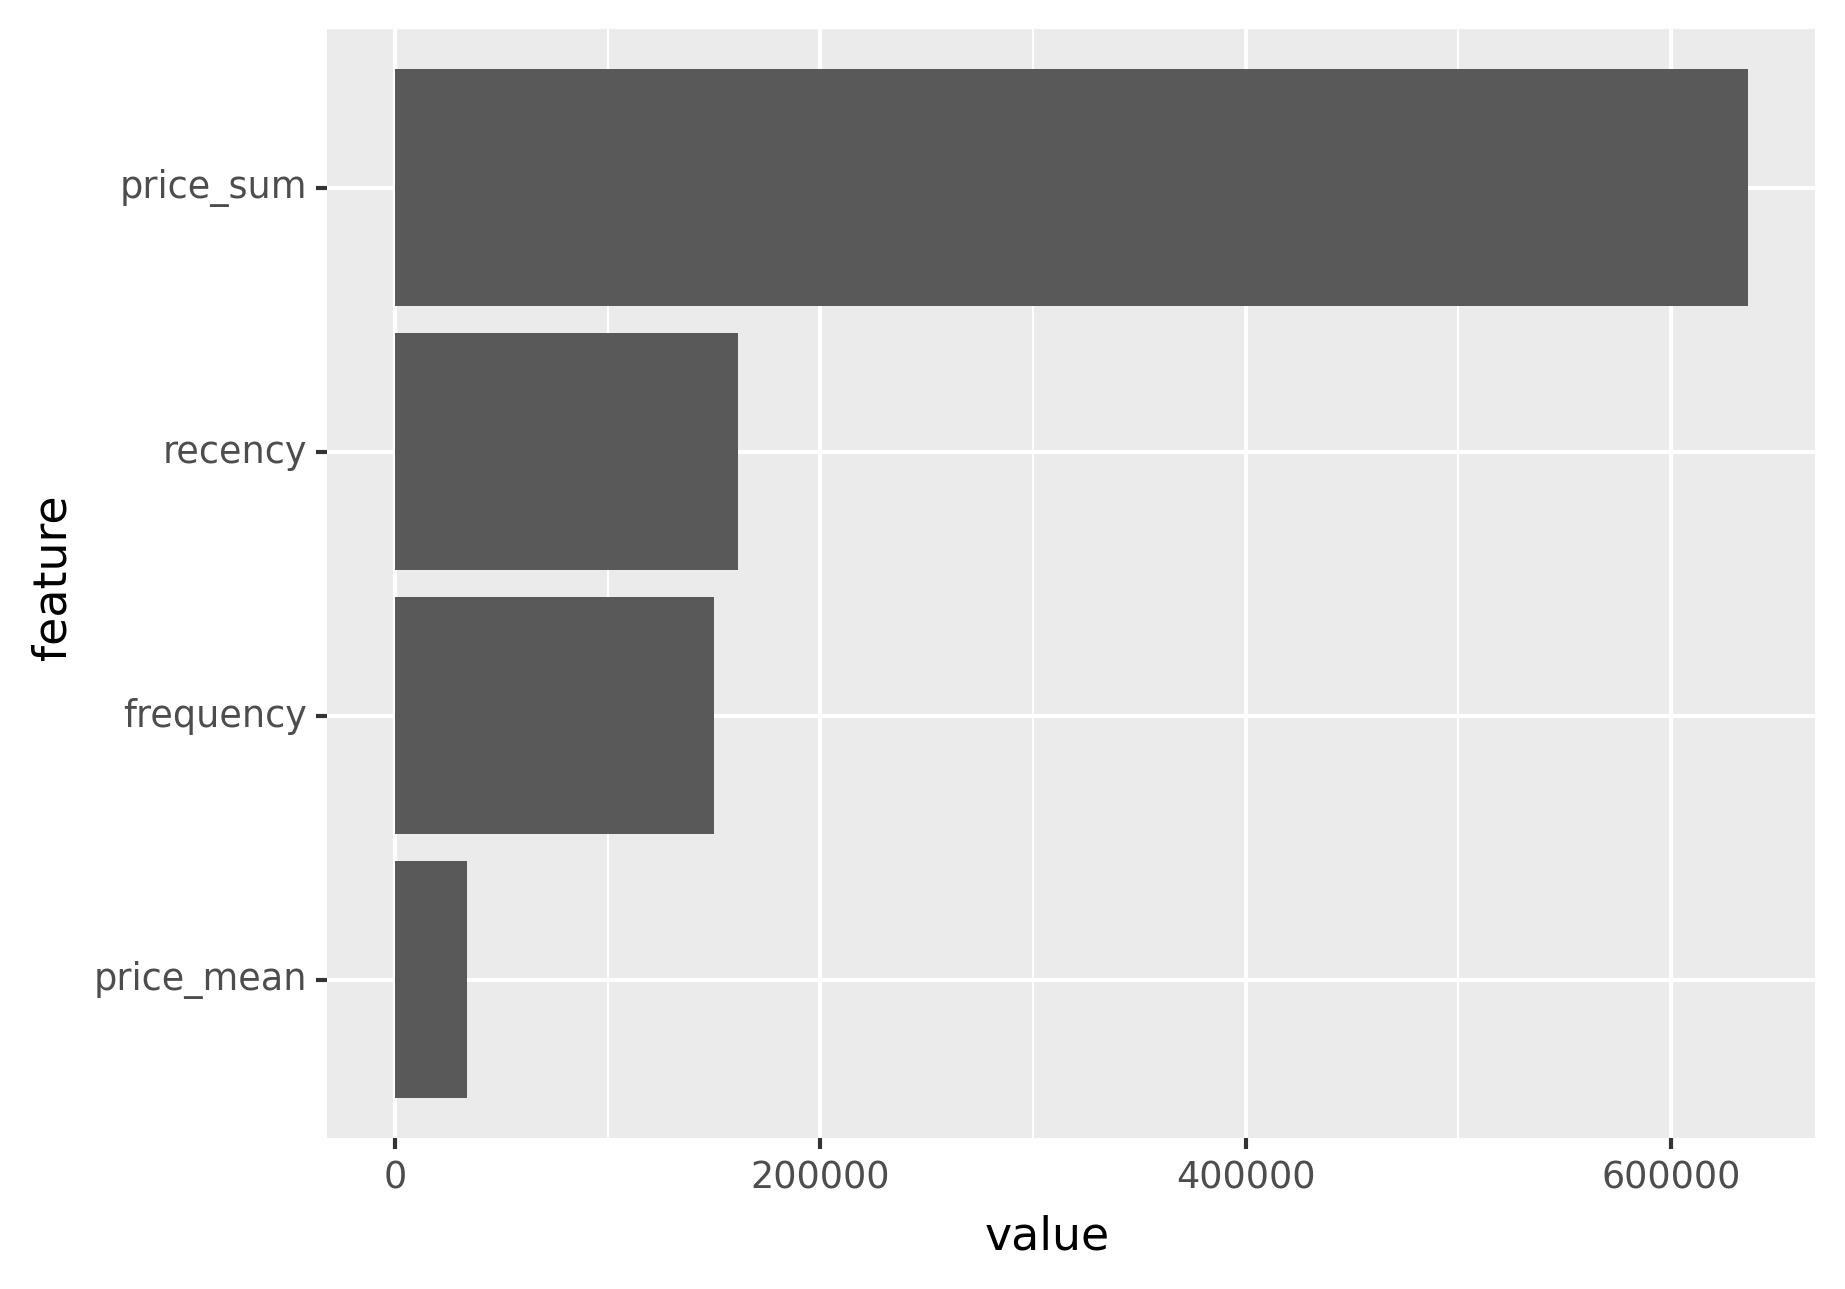

<ggplot: (8770930457381)>

In [158]:
pn.ggplot( imp_spend_amount_df, 
    pn.aes('feature', 'value')
) \
      + pn.geom_col() \
      + pn.coord_flip()
# changing code with Seaborn

In [159]:
# Importance - Spenc Probability Model
imp_spend_prob_dict = xgb_clf_model \
      .best_estimator_ \
      .get_booster() \
      .get_score(importance_type = 'gain')

In [160]:
imp_spend_prob_df = pd.DataFrame(
    data = {
        'feature':list(imp_spend_prob_dict.keys()),
        'value':list(imp_spend_prob_dict.values())
    }
) \
    .assign(
        feature = lambda x: cat.cat_reorder(x['feature'], x['value'])
    )

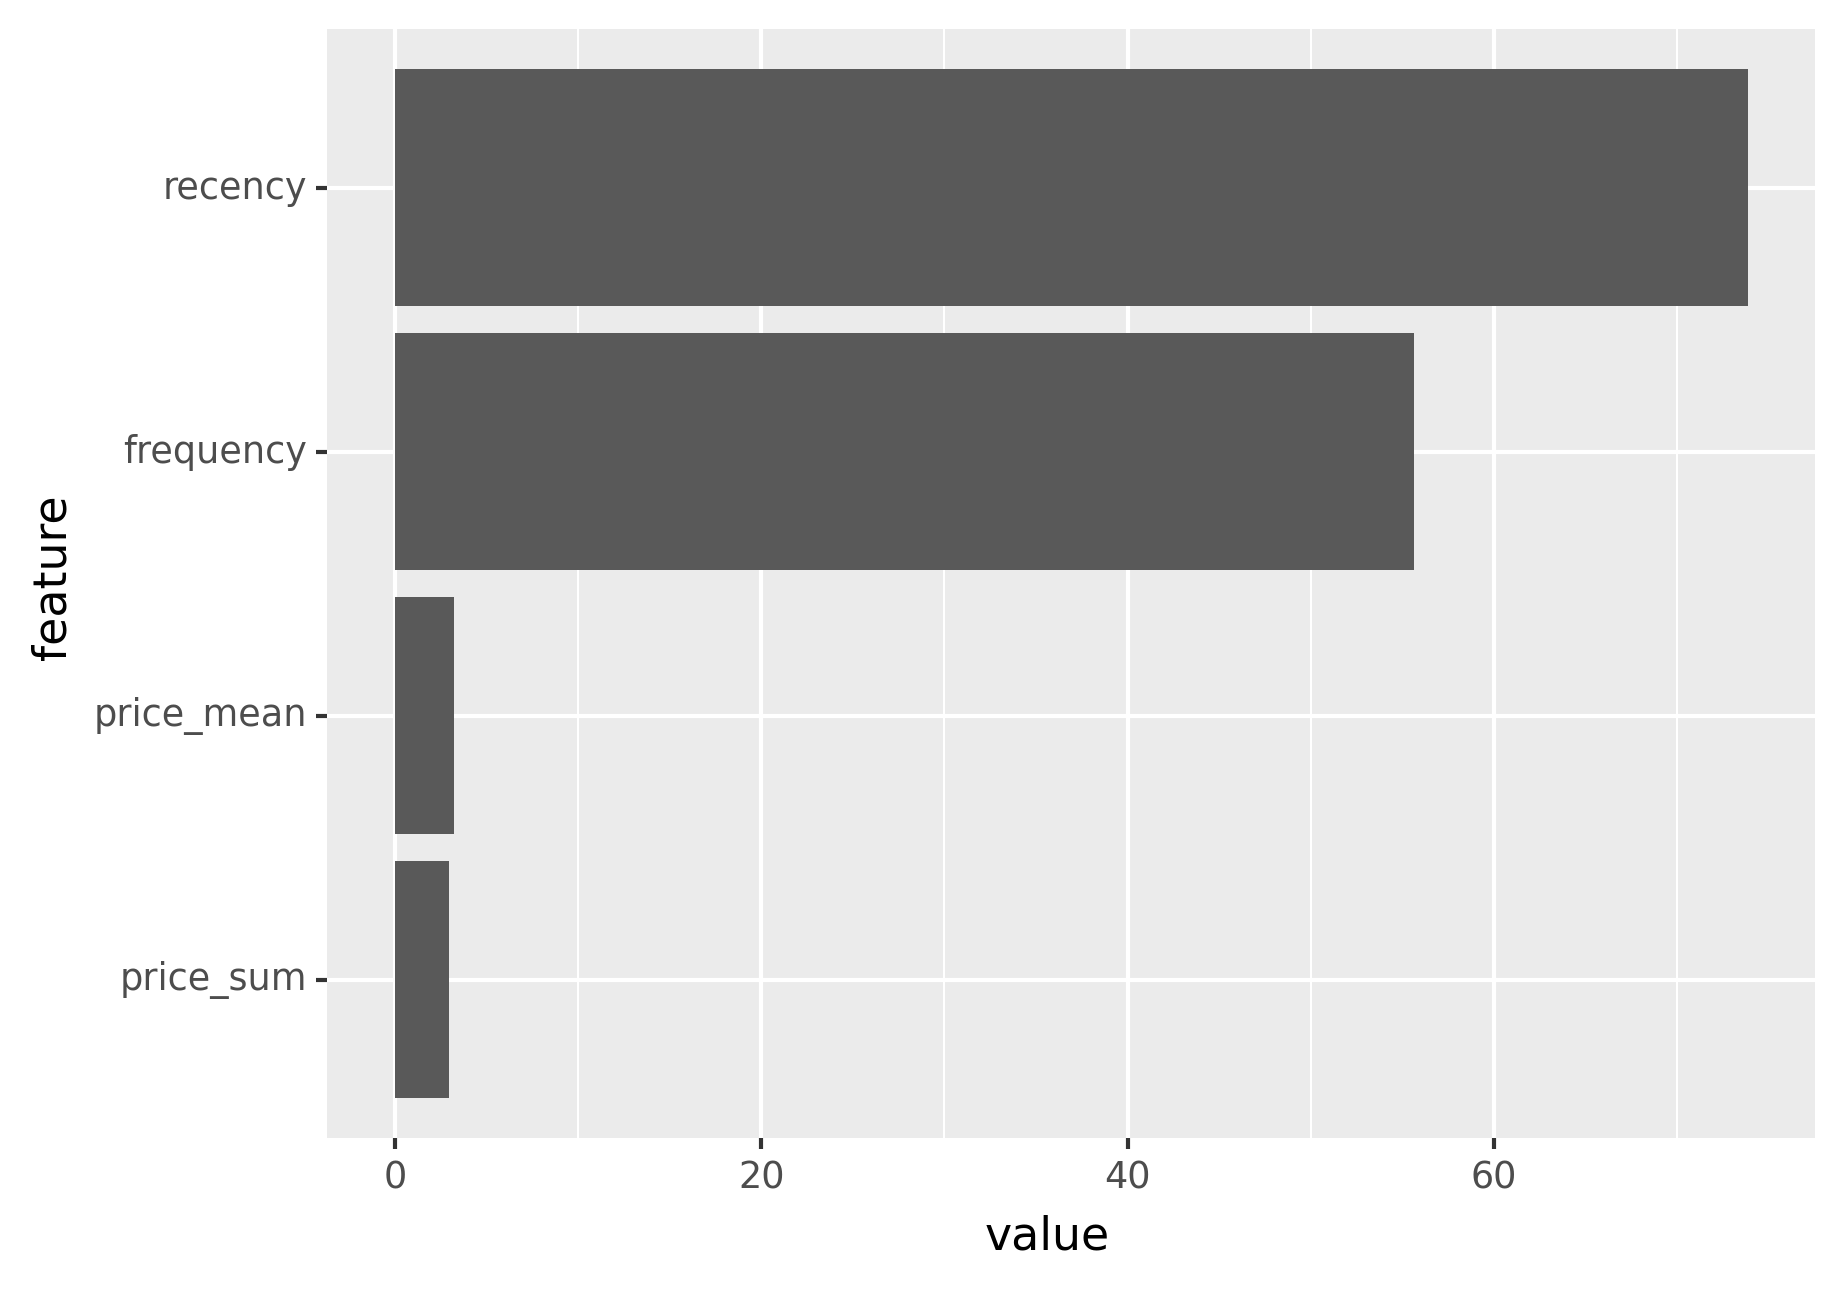

<ggplot: (8770930915816)>

In [161]:
pn.ggplot( imp_spend_prob_df,
          pn.aes('feature', 'value')
          ) \
      + pn.geom_col() \
      + pn.coord_flip()  

In [162]:
# Save Predictions
predictions_df = pd.concat(
    [
    pd.DataFrame(predictions_reg).set_axis(['pred_spend'], axis = 1),
    pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis = 1),
    features_df.reset_index()
    ],
    axis = 1
)

In [163]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
0,0.761482,0.200448,1,-455.0,1,11.77,11.770000,0.00,0.0
1,1.724120,0.210031,2,-444.0,2,89.00,44.500000,0.00,0.0
2,8.926760,0.340360,3,-127.0,5,139.47,27.894000,16.99,1.0
3,7.594741,0.340360,4,-110.0,4,100.50,25.125000,0.00,0.0
4,16.058043,0.553008,5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...,...,...,...
23565,0.864881,0.204490,23566,-372.0,1,36.00,36.000000,0.00,0.0
23566,0.864881,0.204490,23567,-372.0,1,20.97,20.970000,0.00,0.0
23567,3.292585,0.237830,23568,-344.0,3,121.70,40.566667,0.00,0.0
23568,0.864881,0.204490,23569,-372.0,1,25.74,25.740000,0.00,0.0
